# Testing cropping MRIs

- Test cropping 100x100x100 in center. 
- Compare crop with Nigri's work
- Test with AntsPy or Numpy

In [53]:
import os
import sys
import time
module_path = os.path.abspath('../utils')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from deepbrain import Extractor
import ants

# from skull_stripping_ants.s3 import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [3]:
main_dir = '/home/lucasthim1/alzheimer_data/test/002_S_4270/'
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3/"
input_path = "/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii"
atlas_path = '/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii'

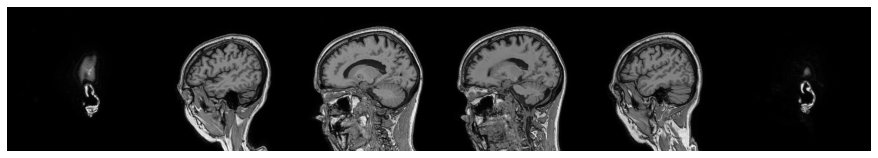

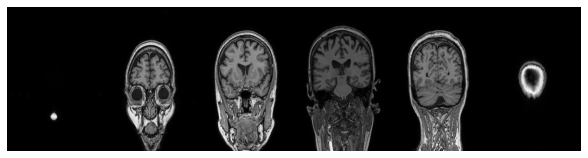

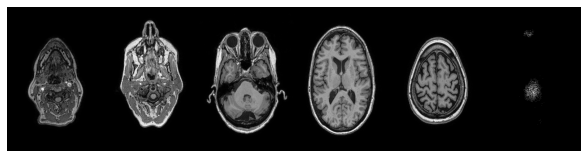

In [4]:
moving = ants.image_read(input_path)
moving.plot(axis =0,figsize=2,nslices=6)
moving.plot(axis =1,figsize=2,nslices=6)
moving.plot(axis =2,figsize=2,nslices=6)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



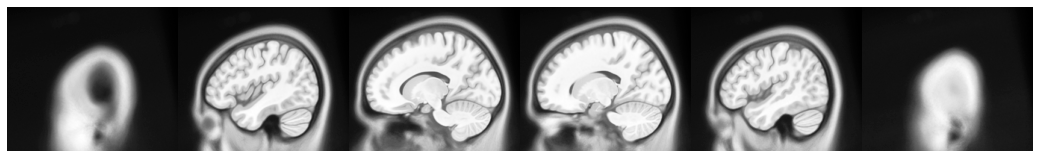

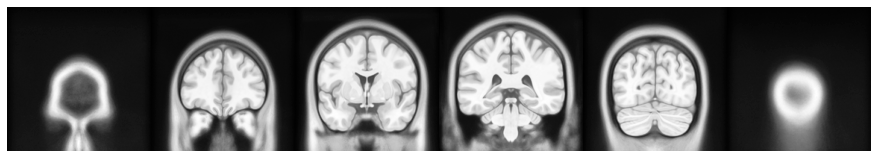

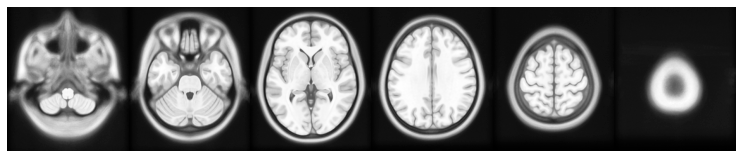

In [5]:
fixed = ants.image_read(atlas_path)
fixed.plot(axis =0,figsize=2,nslices=6)
fixed.plot(axis =1,figsize=2,nslices=6)
fixed.plot(axis =2,figsize=2,nslices=6)

In [47]:
def plot_intensity(image,title = 'Voxel Intensity Visualization',cumulative=False,log_scale = True):

    if type(image) is np.ndarray:
        img_flatten = image.ravel()
    else:
        img_flatten = image.numpy().ravel()
    if cumulative:
        sns.histplot(img_flatten,bins=100,cumulative=True,stat='density',log_scale=[False, log_scale])
    else:
        sns.histplot(img_flatten,bins=100,log_scale=[False, log_scale])
    plt.title(title)
    plt.xlabel('Voxel intensity')
    plt.show()

def get_mean_and_std(img,lower_bound=0.02,upper_bound = 99.8):
    lower_perc,upper_perc = get_percentiles(img,lower_bound=lower_bound,upper_bound=upper_bound)
    img_flatten = img.numpy().ravel()
    
    img_flatten[img_flatten > upper_perc] = upper_perc
    img_flatten[img_flatten < lower_perc] = lower_perc

    return img_flatten.mean(),img_flatten.std()

def get_percentiles(img,lower_bound=0.02,upper_bound = 99.8):
    img_flatten = img.numpy().ravel()
    lower_perc = np.percentile(img_flatten,q=lower_bound)
    upper_perc = np.percentile(img_flatten,q=upper_bound)
    return lower_perc,upper_perc

def scale_image_linearly(img_array:np.ndarray,lower_bound,upper_bound):
    img_array = (img_array - lower_bound) / (upper_bound - lower_bound)
    return img_array

def clip_image_intensity(image:np.ndarray,lower_threshold,upper_threshold):
    image[image > upper_threshold] = upper_threshold
    image[image < lower_threshold] = lower_threshold
    return image

def get_atlas_thresholds(atlas_path = None,lower_bound=0.02,upper_bound=99.8):
    
    if atlas_path is None: return (0.05545412003993988, 92.05744171142578) #for 0.02 and 99.8

    fixed = ants.image_read(atlas_path)
    return get_percentiles(fixed,lower_bound=lower_bound, upper_bound = upper_bound)

def apply_clipping_and_normalization(image, lower_bound = 0.02, upper_bound = 99.8):

    lower_threshold,upper_threshold = get_percentiles(image,lower_bound=lower_bound, upper_bound = upper_bound)
    image_clipped = clip_image_intensity(image.numpy(),lower_threshold=lower_threshold, upper_threshold=upper_threshold)
    lower_atlas_threshold, upper_atlas_threshold = get_atlas_thresholds()
    image_scaled = scale_image_linearly(image_clipped,lower_atlas_threshold,upper_atlas_threshold)
    return image_scaled

def crop_image(image,bbox_size = 100,center_dim = None):
    if center_dim is None:
        center_dim = [int(np.ceil(x/2)) for x in image.shape]
    lower_dim = [int(x - bbox_size/2) for x in center_dim]
    upper_dim = [int(x + bbox_size/2) for x in center_dim]

    cropped_img =  ants.crop_indices(image,lowerind = lower_dim,upperind = upper_dim)
    return cropped_img

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Applying Normalization

In [41]:
moving

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (170, 256, 256)
	 Spacing    : (1.2, 1.0, 1.0)
	 Origin     : (125.6703, 148.9712, -93.6403)
	 Direction  : [-0.9851 -0.0142 -0.1712  0.0276 -0.9967 -0.0761 -0.1696 -0.0797  0.9823]

In [37]:
moving_normalized = apply_clipping_and_normalization(image=moving)
moving_normalized = ants.from_numpy(moving_normalized, direction=moving.direction)


## Applying Registration

In [38]:
mytx = ants.registration(fixed=fixed , moving=moving_normalized, type_of_transform='Rigid' ,grad_step=0.1)
warpedimage_normalized = ants.apply_transforms(fixed=fixed, moving=moving_normalized, transformlist=mytx['fwdtransforms'])

In [18]:
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Rigid' ,grad_step=0.1)
warpedimage = ants.apply_transforms(fixed=fixed, moving=moving, transformlist=mytx['fwdtransforms'])

## Comparing Images

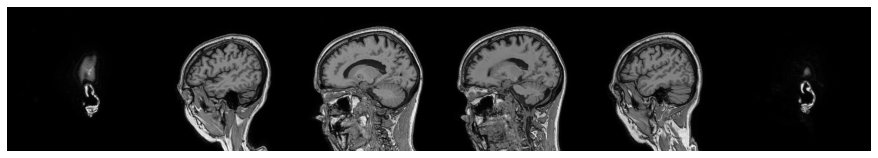

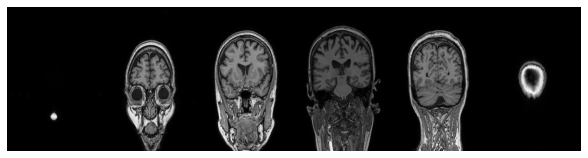

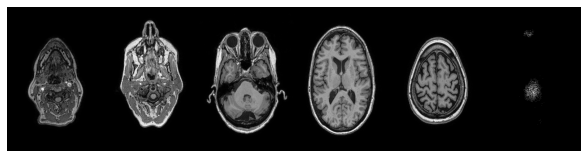

In [39]:
moving.plot(axis =0,figsize=2,nslices=6)
moving.plot(axis =1,figsize=2,nslices=6)
moving.plot(axis =2,figsize=2,nslices=6)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



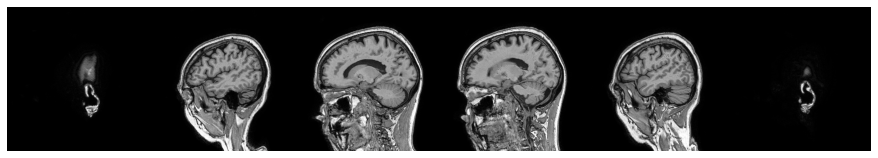

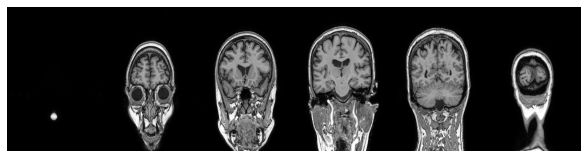

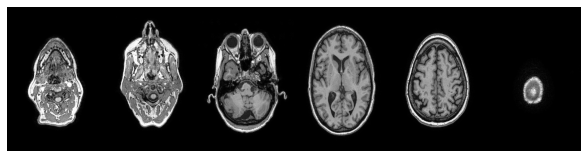

In [40]:
moving_normalized.plot(axis =0,figsize=2,nslices=6)
moving_normalized.plot(axis =1,figsize=2,nslices=6)
moving_normalized.plot(axis =2,figsize=2,nslices=6)

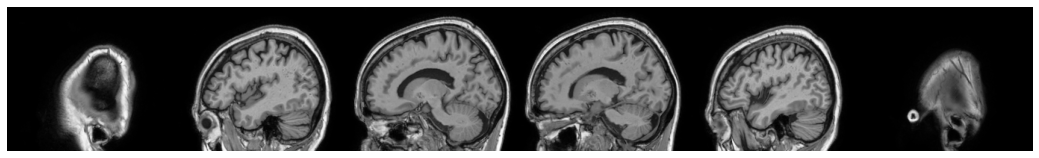

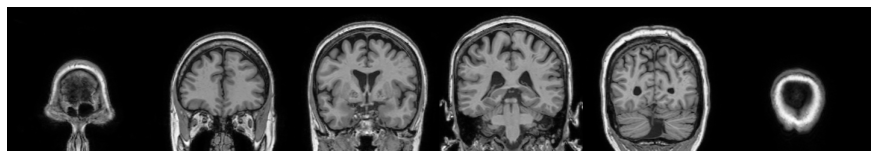

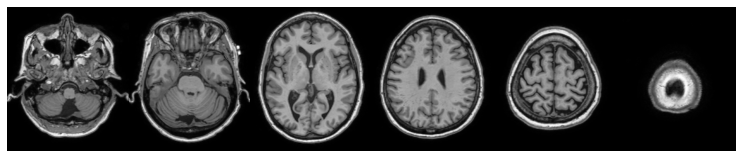

In [42]:
warpedimage.plot(axis =0,figsize=2,nslices=6)
warpedimage.plot(axis =1,figsize=2,nslices=6)
warpedimage.plot(axis =2,figsize=2,nslices=6)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



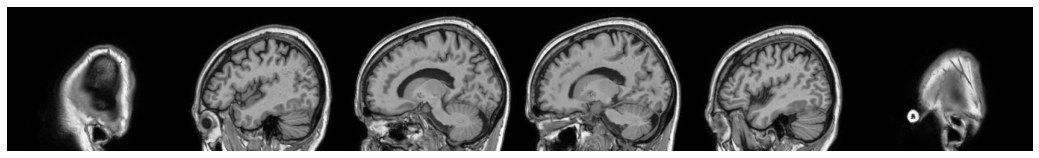

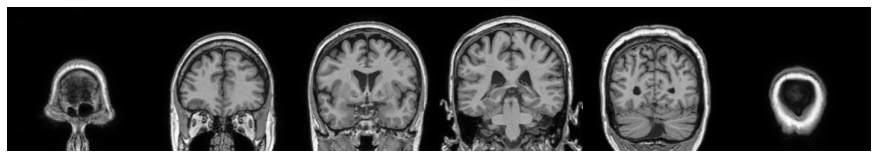

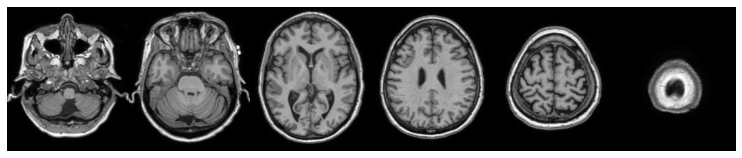

In [43]:
warpedimage_normalized.plot(axis =0,figsize=2,nslices=6)
warpedimage_normalized.plot(axis =1,figsize=2,nslices=6)
warpedimage_normalized.plot(axis =2,figsize=2,nslices=6)

## Skull stripping

In [55]:
def apply_skull_strip(img):
    start = time.time()

    img = warpedimage.numpy()
    probability = 0.5

    # execute brain extraction
    ext = Extractor()
    print("Running DeepBrain Skull Stripping...")
    prob = ext.run(img) 
    mask = prob > probability

    # apply mask
    final_img = img.copy()
    final_img[~mask] = 0
    final_img_name = os.path.splitext(os.path.splitext(os.path.basename(input_path))[0])[0]
    output_file_path = output_path + '/' + final_img_name + "_masked_deepbrain.nii.gz"

    final_img_ants = ants.from_numpy(final_img,direction = warpedimage.direction)
    # final_img_nii.header.get_xyzt_units()
    # final_img_nii.to_filename(output_file_path)
    print('Skull stripped image saved as :',output_file_path)

    total_time = (time.time() - start)
    print('Done with skull stripping! Process took %.2f sec) \n' % total_time)
    return final_img_ants

In [56]:
normalized_stripped = apply_skull_strip(warpedimage_normalized)
stripped = apply_skull_strip(warpedimage)


Instructions for updating:
Use tf.gfile.GFile.

Running DeepBrain Skull Stripping...
Skull stripped image saved as : /home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3//ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz
Done with skull stripping! Process took 4.20 sec) 

Running DeepBrain Skull Stripping...
Skull stripped image saved as : /home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3//ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz
Done with skull stripping! Process took 2.58 sec) 



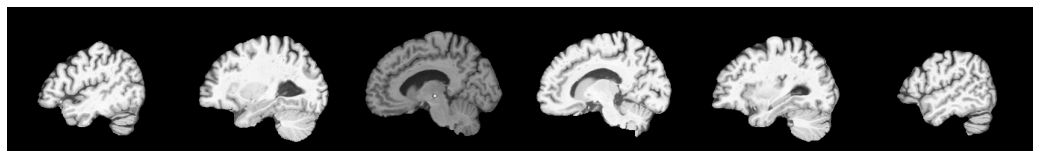

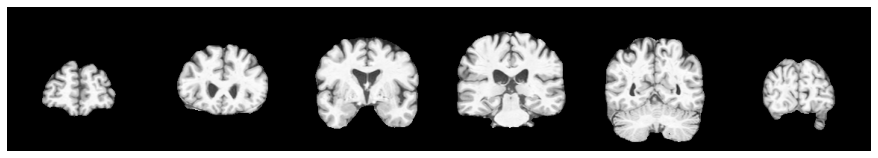

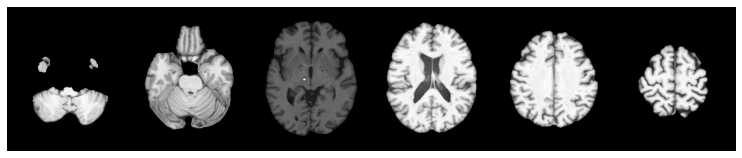

In [57]:
stripped.plot(axis =0,figsize=2,nslices=6)
stripped.plot(axis =1,figsize=2,nslices=6)
stripped.plot(axis =2,figsize=2,nslices=6)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



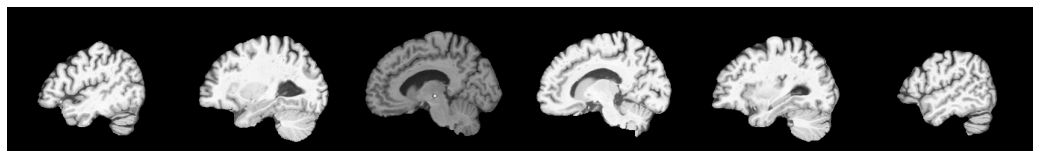

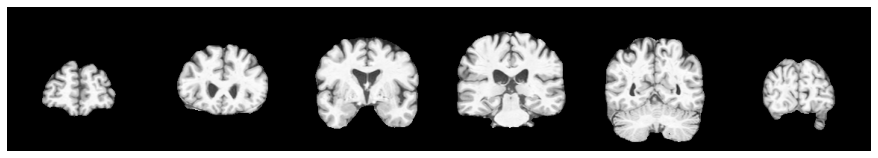

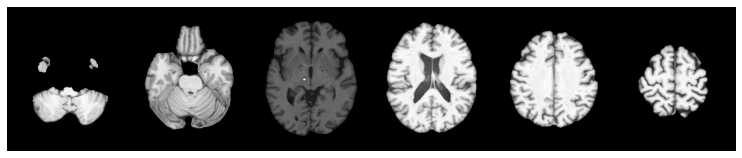

In [58]:
normalized_stripped.plot(axis =0,figsize=2,nslices=6)
normalized_stripped.plot(axis =1,figsize=2,nslices=6)
normalized_stripped.plot(axis =2,figsize=2,nslices=6)

## Cropping Images

In [59]:
print("Moving Image size:",moving.shape)
print("Atlas size:",fixed.shape)
print("Registered Image size:",stripped.shape)
print("Registered Normalized Image size:",normalized_stripped.shape)

Moving Image size: (170, 256, 256)
Atlas size: (193, 229, 193)
Registered Image size: (193, 229, 193)
Registered Normalized Image size: (193, 229, 193)


/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [60]:
print("Center of images:")

print("Atlas size:",[int(np.ceil(x/2)) for x in fixed.shape])
print("Moving Image size:",[int(np.ceil(x/2)) for x in moving.shape])
print("Registered Image size:",[int(np.ceil(x/2)) for x in stripped.shape])
print("Registered Image size:",[int(np.ceil(x/2)) for x in normalized_stripped.shape])

Center of images:
Atlas size: [97, 115, 97]
Moving Image size: [85, 128, 128]
Registered Image size: [97, 115, 97]
Registered Image size: [97, 115, 97]


In [26]:
center_dim = [int(np.ceil(x/2)) for x in warpedimage.shape]
lower_dim = [int(x - 50) for x in center_dim]
upper_dim = [int(x + 50) for x in center_dim]

In [62]:
cropped_img =  ants.crop_indices(stripped,lowerind = lower_dim,upperind = upper_dim)
cropped_img_normalized =  ants.crop_indices(normalized_stripped,lowerind = lower_dim,upperind = upper_dim)

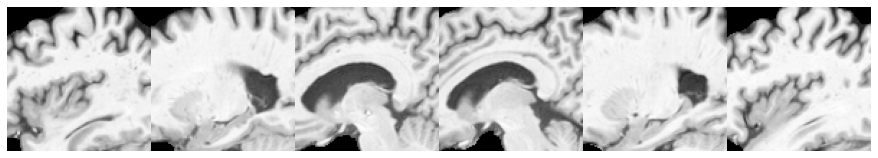

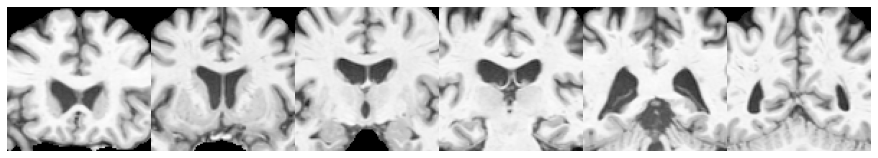

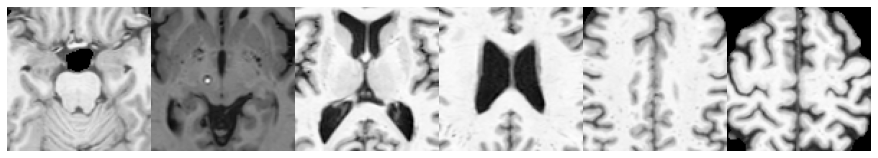

In [63]:
cropped_img.plot(axis =0,figsize=2,nslices=6)
cropped_img.plot(axis =1,figsize=2,nslices=6)
cropped_img.plot(axis =2,figsize=2,nslices=6)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



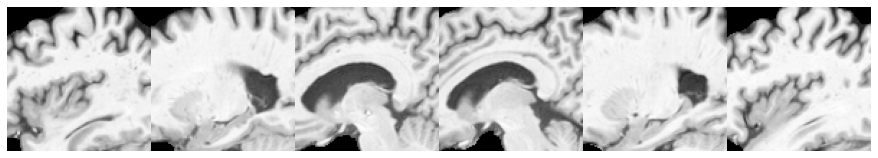

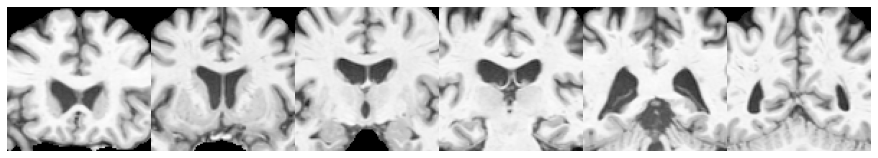

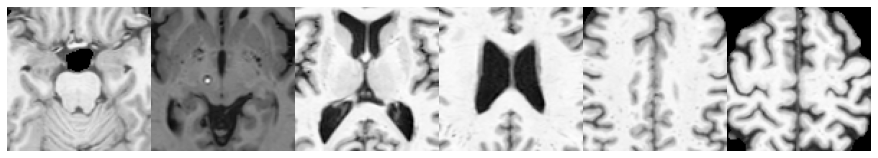

In [64]:
cropped_img_normalized.plot(axis =0,figsize=2,nslices=6)
cropped_img_normalized.plot(axis =1,figsize=2,nslices=6)
cropped_img_normalized.plot(axis =2,figsize=2,nslices=6)